# Example usage of IVIM package
---
In this example we will utilize various functionality of the IVIM Python package for a typical usage scenario in the liver. We will:

1.   Optimize the b-value acquisition scheme
2.   Simulate noisy IVIM signal
3.   Fit IVIM parameters to the noisy data






In [ ]:
# !git clone https://github.com/oscarjalnefjord/ivim.git &> /dev/null
# !pip install ivim &> /dev/null
# !pip uninstall ivim -y
!pip install git+https://github.com/ElinaPetersson/ivim_ep.git &> /dev/null # changed the setup.py file

import pandas as pd
import os
import numpy as np
import ivim
from ivim.models import DIFFUSIVE_REGIME

/usr/local/lib/python3.10/dist-packages/ivim/preproc/ec_susc.py:12: UserWarning: FSL installation not found. Correction for motion, eddy currents and susceptibility induced distorsions will not work.
  warnings.warn('FSL installation not found. Correction for motion, eddy currents and susceptibility induced distorsions will not work.')


## 1. Optimize b-value scheme
Typical parameter values for the liver are D=1-1.2e-3$mm^2/s$, f=0.15-0.30 and D*=50e-3$mm^2/s$

In [ ]:
# Create a phantom
D = np.array([[1]])*1e-3
f = np.array([[0.15]])
Dstar = np.array([[20e-3]])
SNR=100

# Optimize b-values using crlb
b,a = ivim.optimize.crlb(D.ravel(),f.ravel(),regime=DIFFUSIVE_REGIME,bmax=1000,fitK=False,minbias=False,SNR=SNR,bthr=200,Dstar=Dstar.ravel())

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


## 2. Simulate noisy IVIM signal

In [ ]:
# Save b-values as .bval
n = np.round(a*14).astype(int)
while sum(n) > 14: n[np.argmax(n)]-=1
b = [b[i] for i in range(len(n)) for _ in range(n[i])]
bval_file = os.path.join(os.getcwd(),'opt.bval')
ivim.io.base.write_bval(bval_file, b)

# Save true parameter values
D_file = os.path.join(os.getcwd(),'true_D.nii.gz')
f_file = os.path.join(os.getcwd(),'true_f.nii.gz')
Dstar_file = os.path.join(os.getcwd(),'true_Dstar.nii.gz')
ivim.io.base.write_im(D_file, D)
ivim.io.base.write_im(f_file, f)
ivim.io.base.write_im(Dstar_file, Dstar)


# Simulate noisy IVIM signal with kurtosis
n_noise=1000
noise_sigma=1/SNR
K_file = os.path.join(os.getcwd(),'true_K.nii.gz')
ivim.io.base.write_im(K_file, np.ones_like(D)*0.1) # adjust to vary level of Kurtosis
ivim.sim.noise(D_file=D_file,f_file=f_file,Dstar_file=Dstar_file,K_file=K_file,regime=DIFFUSIVE_REGIME,bval_file=bval_file,noise_sigma=noise_sigma,n_noise=n_noise,outbase=os.path.join(os.getcwd(),'sim'))


## 3. Fit IVIM parameters
Nonlinear least-squares is used in the example to fit parameters to the noisy signal.

In [ ]:
sim_im = os.path.join(os.getcwd(),'sim.nii.gz')
ivim.fit.nlls(im_file=sim_im,bval_file=bval_file,regime=DIFFUSIVE_REGIME,outbase=os.path.join(os.getcwd(),'est'))

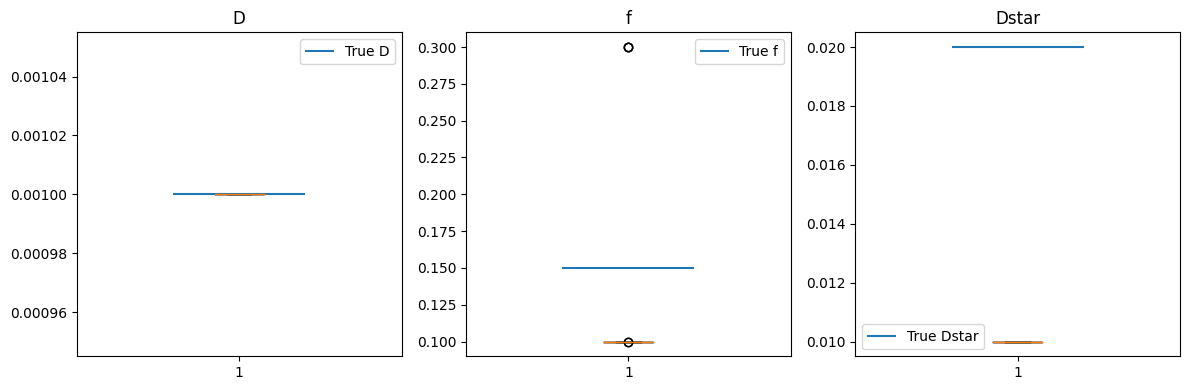

In [ ]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3,figsize=(12,4))
for pidx, p in enumerate(['D','f','Dstar']):
  est_p = ivim.io.base.read_im(f'est_{p}.nii.gz')
  true_p = ivim.io.base.read_im(f'true_{p}.nii.gz')
  ax[pidx].boxplot(est_p.reshape(1,n_noise).T)
  ax[pidx].plot(np.array([0.8,1.2]),true_p.ravel()*np.ones(2),label=f'True {p}')
  ax[pidx].set_title(f'{p}')
  ax[pidx].legend()
plt.tight_layout()
plt.show();


In [ ]:
ivim.io.base.read_bval('sim.bval')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
ivim.io.base.read_im('sim.nii.gz').shape

(1, 1, 1000, 14)